# __BAX-452 Assignment 6:  Random Forest and Decision Tree Classification__    

#### 001 - Yumi Jin

In [28]:
# load packages
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.exceptions import ConvergenceWarning
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.tree import DecisionTreeRegressor, plot_tree

### __1. Random Forest__

#### a) Load the data and drop 'Ticker Symbol’, ‘Period Ending’, ‘For Year'

In [2]:
# read in the data
data = pd.read_csv('/Users/yumi/ucdavis/Winter Quarter/BAX-452/Assignments/HW6/fundamentals.csv',
                   index_col = 0)

In [3]:
data.head(5)

,Ticker Symbol,Period Ending,Accounts Payable,Accounts Receivable,Add'l income/expense items,After Tax ROE,Capital Expenditures,Capital Surplus,Cash Ratio,Cash and Cash Equivalents,...,Total Current Assets,Total Current Liabilities,Total Equity,Total Liabilities,Total Liabilities & Equity,Total Revenue,Treasury Stock,For Year,Earnings Per Share,Estimated Shares Outstanding
0,AAL,2012-12-31,3.068000e+09,-222000000.0,-1.961000e+09,23.0,-1.888000e+09,4.695000e+09,53.0,1.330000e+09,...,7.072000e+09,9.011000e+09,-7.987000e+09,2.489100e+10,1.690400e+10,2.485500e+10,-367000000.0,2012.0,-5.60,3.350000e+08
1,AAL,2013-12-31,4.975000e+09,-93000000.0,-2.723000e+09,67.0,-3.114000e+09,1.059200e+10,75.0,2.175000e+09,...,1.432300e+10,1.380600e+10,-2.731000e+09,4.500900e+10,4.227800e+10,2.674300e+10,0.0,2013.0,-11.25,1.630222e+08
2,AAL,2014-12-31,4.668000e+09,-160000000.0,-1.500000e+08,143.0,-5.311000e+09,1.513500e+10,60.0,1.768000e+09,...,1.175000e+10,1.340400e+10,2.021000e+09,4.120400e+10,4.322500e+10,4.265000e+10,0.0,2014.0,4.02,7.169154e+08
3,AAL,2015-12-31,5.102000e+09,352000000.0,-7.080000e+08,135.0,-6.151000e+09,1.159100e+10,51.0,1.085000e+09,...,9.985000e+09,1.360500e+10,5.635000e+09,4.278000e+10,4.841500e+10,4.099000e+10,0.0,2015.0,11.39,6.681299e+08
4,AAP,2012-12-29,2.409453e+09,-89482000.0,6.000000e+05,32.0,-2.711820e+08,5.202150e+08,23.0,5.981110e+08,...,3.184200e+09,2.559638e+09,1.210694e+09,3.403120e+09,4.613814e+09,6.205003e+09,-27095000.0,2012.0,5.29,7.328355e+07


In [4]:
# drop 'Ticker Symbol', 'Period Ending', and 'For Year'
data = data.drop(columns = ['Ticker Symbol', 'Period Ending', 'For Year'], axis = 1)

In [5]:
# check for missing values
missing_values = data.isnull().sum()/len(data)
missing_values[missing_values > 0]

Cash Ratio                      0.167883
Current Ratio                   0.167883
Quick Ratio                     0.167883
Earnings Per Share              0.122965
Estimated Shares Outstanding    0.122965
dtype: float64

In [6]:
# since there is only a small percent of data missing in rows, we remove rows with NA values
data = data.dropna()

In [7]:
missing_values = data.isnull().sum()/len(data)
missing_values[missing_values > 0]

Series([], dtype: float64)

In [8]:
data.head()

,Accounts Payable,Accounts Receivable,Add'l income/expense items,After Tax ROE,Capital Expenditures,Capital Surplus,Cash Ratio,Cash and Cash Equivalents,Changes in Inventories,Common Stocks,...,Total Assets,Total Current Assets,Total Current Liabilities,Total Equity,Total Liabilities,Total Liabilities & Equity,Total Revenue,Treasury Stock,Earnings Per Share,Estimated Shares Outstanding
0,3.068000e+09,-222000000.0,-1.961000e+09,23.0,-1.888000e+09,4.695000e+09,53.0,1.330000e+09,0.0,127000000.0,...,2.351000e+10,7.072000e+09,9.011000e+09,-7.987000e+09,2.489100e+10,1.690400e+10,2.485500e+10,-367000000.0,-5.60,3.350000e+08
1,4.975000e+09,-93000000.0,-2.723000e+09,67.0,-3.114000e+09,1.059200e+10,75.0,2.175000e+09,0.0,5000000.0,...,4.227800e+10,1.432300e+10,1.380600e+10,-2.731000e+09,4.500900e+10,4.227800e+10,2.674300e+10,0.0,-11.25,1.630222e+08
2,4.668000e+09,-160000000.0,-1.500000e+08,143.0,-5.311000e+09,1.513500e+10,60.0,1.768000e+09,0.0,7000000.0,...,4.322500e+10,1.175000e+10,1.340400e+10,2.021000e+09,4.120400e+10,4.322500e+10,4.265000e+10,0.0,4.02,7.169154e+08
3,5.102000e+09,352000000.0,-7.080000e+08,135.0,-6.151000e+09,1.159100e+10,51.0,1.085000e+09,0.0,6000000.0,...,4.841500e+10,9.985000e+09,1.360500e+10,5.635000e+09,4.278000e+10,4.841500e+10,4.099000e+10,0.0,11.39,6.681299e+08
4,2.409453e+09,-89482000.0,6.000000e+05,32.0,-2.711820e+08,5.202150e+08,23.0,5.981110e+08,-260298000.0,7000.0,...,4.613814e+09,3.184200e+09,2.559638e+09,1.210694e+09,3.403120e+09,4.613814e+09,6.205003e+09,-27095000.0,5.29,7.328355e+07


---

#### b) Split data set with 70% train and 30% test then build random forest model.  Default every (hyper-)parameter then compute MSE. (15 pts)

In [9]:
# set seed for reproducability 
np.random.seed(seed = 22)

In [10]:
# seperate features and target variable
X = data.drop(['Estimated Shares Outstanding'], axis = 1)
y = data['Estimated Shares Outstanding']

# split data set with 70% train and 30% test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 22)

# build random forest model
rf_model = RandomForestRegressor(n_estimators = 100, random_state = 22)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=22)

In [11]:
# predict on the test set
y_pred = rf_model.predict(X_test)

# compute the Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 1.420835312288357e+17


__Answer:__    
The Random Forest model, with all hyperparameters set to their default values, resulted in a Mean Squared Error (MSE) of approximately 1.42e+17 when applied to the test set.

---

#### c) Build random forest with min_samples_split set to 3.  Compare with random forest model in (b).  Explain. (15 pts)

In [12]:
# create a Random Forest model with 'min_samples_split' set to 3
rf_model_2 = RandomForestRegressor(min_samples_split = 3, n_estimators = 100, random_state = 22)
rf_model_2.fit(X_train, y_train)

# predict on the test set with the new model
y_pred_2 = rf_model_2.predict(X_test)

# compute the Mean Squared Error (MSE) for the new model
mse_2 = mean_squared_error(y_test, y_pred_2)

print("MSE with min_samples_split = 2 Random Forest model:", mse)
print("MSE with min_samples_split = 3 Random Forest model:", mse_2)

MSE with min_samples_split = 2 Random Forest model: 1.420835312288357e+17
MSE with min_samples_split = 3 Random Forest model: 1.4918633944424627e+17


__Interpretation:__  

For the Random Forest model with the 'min_samples_split' parameter set to 3, the MSE is approximately 1.49e+17. Compared to the model with default parameters (where the MSE was approximately 1.42e+17), there is __an increase in MSE__, indicating that adjusting the 'min_samples_split' parameter doesn't improved the overall performance of the model.  
  
The 'min_samples_split' parameter determines the minimum number of samples required to split an internal node. A smaller 'min_samples_split' value can lead to deeper, more detailed trees, which might improve the fit on the training set but also can increase the risk of overfitting. In our case, setting 'min_samples_split' to 2 result in better performance on the test set.

---

#### d) Use "Mean Decrease in Impurity" and "Permutation Feature Importance" to compute the variable importance of the random forest in (c).  Explain how each method computes the variable importance and compare their results. (15 pts)

In [13]:
# compute Mean Decrease in Impurity (MDI) [aka Gini importance]
mdi = rf_model_2.feature_importances_

# compute Permutation Feature Importance
pfi = permutation_importance(rf_model_2, X_test, y_test, n_repeats = 10, random_state = 22)
pfi_mean = pfi.importances_mean

In [14]:
# dataframe to compare mdi and permutation for each feature 
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'MDI': mdi,
    'Permutation': pfi_mean
})
print(feature_importance_df)

                       Feature       MDI   Permutation
0             Accounts Payable  0.007444 -1.356609e-03
1          Accounts Receivable  0.001965 -1.710548e-03
2   Add'l income/expense items  0.002356 -3.262737e-04
3                After Tax ROE  0.001063  5.742017e-07
4         Capital Expenditures  0.002193  1.166076e-03
..                         ...       ...           ...
69           Total Liabilities  0.016384  6.260271e-03
70  Total Liabilities & Equity  0.149227  8.875662e-02
71               Total Revenue  0.001450 -2.905831e-04
72              Treasury Stock  0.001958  7.751668e-04
73          Earnings Per Share  0.057232  4.289355e-02

[74 rows x 3 columns]


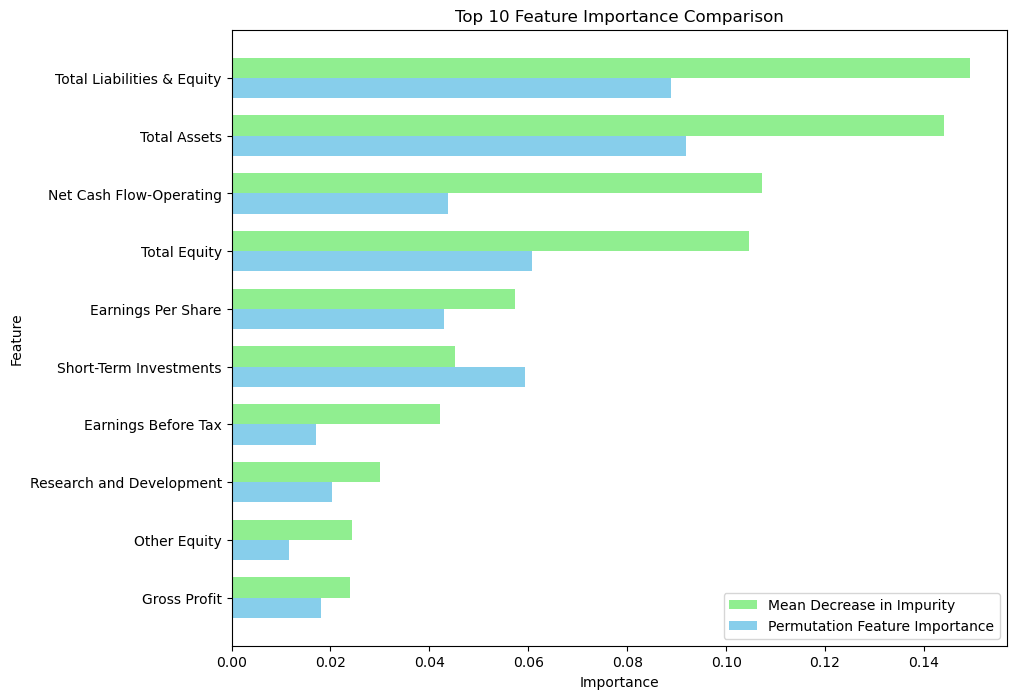

In [15]:
# sort feature importance and select the top 10
feature_importance_df_sorted = feature_importance_df.sort_values(by = 'MDI', ascending = False)
feature_importance_df_sorted = feature_importance_df_sorted.head(10)

# create bar chart
plt.figure(figsize = (10, 8)) 

# set the width of the bars
bar_width = 0.35

# set the positions for the bars
index = np.arange(len(feature_importance_df_sorted))

# plot Mean Decrease in Impurity for the top 10 features
plt.barh(index, feature_importance_df_sorted['MDI'], bar_width, 
         color = 'lightgreen', label = 'Mean Decrease in Impurity')

# plot Permutation Feature Importance for the top 10 features
plt.barh(index + bar_width, feature_importance_df_sorted['Permutation'], bar_width, 
         color = 'skyblue', label = 'Permutation Feature Importance')

plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Feature Importance Comparison')
plt.yticks(index + bar_width / 2, feature_importance_df_sorted['Feature'])
plt.legend()
# invert y-axis to show the most important features at the top
plt.gca().invert_yaxis()
plt.show()

__Interpretation:__  

__Mean Decrease in Impurity (MDI):__ Calcultaes how much each split contributes to a reduction in deviance. Features leading to bigger impurity decreases are more important. This method can be biased towards numerical features and features with many categories.  

__Permutation Feature Importance:__ Calculated post-model building by evaluating the increase in the model's prediction error after permuting the feature's values. A feature is considered important if shuffling its values significantly increases the error.  


According to the bar chart which compares the top 10 features based on MDI and Permutation:  
- Total Liabilities & Equity: Shows a significant difference between the two importance scores, indicating it affects the model's performance more than tree impurity.  
- Total Assets, Net Cash Flow-Operating, Total Equity: Valued more by the permutation method, suggesting they impact model error more than impurity reduction.  
- Earnings Per Share, Short-Term Investments: Have some differences between the importance measures, reflecting varied impacts on the model.  
- Research and Development, Other Equity, Gross Profit: Ranked lower in both methods but show discrepancies between MDI and permutation importance.  

This indicates a variation in feature importance assessment, highlighting the need to consider multiple methods for a comprehensive understanding. MDI is biased towards features allowing more unique splits, while permutation importance evaluates actual impact on model performance.


---

#### e) Use the same split to build lasso regression.  Compare with last model (c). (15 pts)

In [16]:
# scale the data 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [17]:
# suppress the convergence warnings
warnings.filterwarnings('ignore', category = ConvergenceWarning)

# determine the optimal alpha value for lasso with CV
lasso_cv = LassoCV(alphas = np.logspace(-6, 10, 15), cv = 5, random_state = 22, max_iter = 50000)
lasso_cv.fit(X_train_scaled, y_train)
optimal_alpha = lasso_cv.alpha_
print("Optimal Alpha:", optimal_alpha)

Optimal Alpha: 51794746.79231202


In [18]:
# set up model on training data with the optimal alpha
lasso = Lasso(alpha = optimal_alpha)
lasso_model = lasso.fit(X_train_scaled, y_train)

# predict on the scaled test set
y_pred_lasso=lasso_model.predict(X_test_scaled)

# compute the Mean Squared Error (MSE) for the Lasso model
mse_lasso = mean_squared_error(y_test, y_pred_lasso)

# print the result
print("Random Forest MSE:", mse_2)
print("Lasso MSE:", mse_lasso)

Random Forest MSE: 1.4918633944424627e+17
Lasso MSE: 1.88511416325568e+17


__Interpretation:__   

The Lasso regression model has a MSE of approximately 1.89e+17, whereas the Random Forest model with min_samples_split set to 3 has an MSE of approximately 1.49e+17.

Comparing the two models, the Random Forest model performs better with a lower MSE, indicating that it makes more accurate predictions for this dataset than the Lasso regression model. Random forest accounts for interactions and eliminates the need for cross validation and it can also handle non-linear relationships better because boootstrap is a nonparametric technique. Thus in our case, random forest may be a better model since lasso results in higher MSE potentially because of non-linear relationships in the data. 

---

### __2. Decision Tree Classification__

#### a) Use the breast cancer dataset to build decision tree classifier to predict the diagnosis.  Split the data into 70% train and 30% test. (10 pts)

In [19]:
# read in the data
data = pd.read_csv('/Users/yumi/ucdavis/Winter Quarter/BAX-452/Assignments/HW6/breast_cancer.csv')

In [20]:
data.head(5)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [21]:
# remove the unnamed column
data = data.loc[:, ~data.columns.str.contains('^Unnamed')]

# drop id column
data = data.drop(['id'], axis = 1)

In [22]:
data.head(5)

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [23]:
# check for missing values
missing_values = data.isnull().sum()
for i in missing_values:
    if i != 0:
        print(i)
    else:
        break
print('No missing values')

No missing values


In [24]:
# encode the 'diagnosis' column: Malignant (M) as 1 and Benign (B) as 0
data['diagnosis'] = data['diagnosis'].map({'M':1, 'B':0})

# seperate features and target variable
X = data.drop(['diagnosis'], axis = 1)
y = data['diagnosis']

# ensure y is numeric
y = pd.to_numeric(y, errors = 'coerce')

# split data set with 70% train and 30% test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 22)

# build decision tree model
regressor = DecisionTreeRegressor()  
regressor.fit(X_train, y_train)

DecisionTreeRegressor()

---

#### b) Print Confusion matrix and explain.  Hint:  A confusion matrix is a table used in machine learning to visualize the performance of a classification model by showing the actual vs. predicted values, helping to identify the types of errors made by the model.  Typically, the actual labels are on the vertical axis (rows), and the predicted labels are on the horizontal axis (columns). (10 pts)

In [25]:
# make predictions on the test set
y_pred = regressor.predict(X_test)

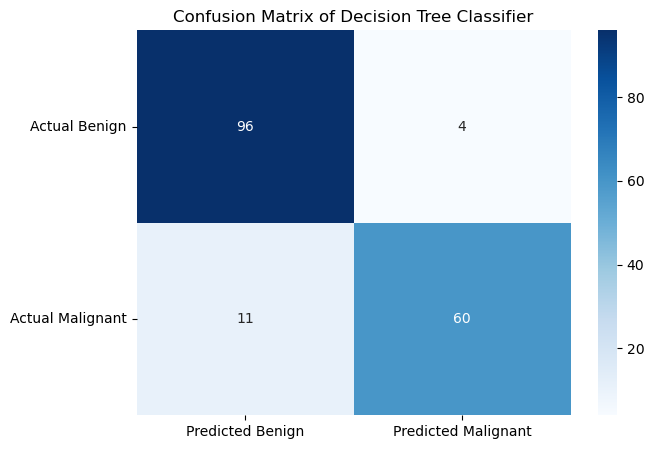

In [30]:
# calculate confusion matrix
c_matrix = confusion_matrix(y_test, y_pred)

# plot confusion matrix
plt.figure(figsize = (7, 5))
sns.heatmap(c_matrix, annot = True, fmt = "d", cmap = 'Blues', 
            xticklabels = ['Predicted Benign', 'Predicted Malignant'], 
            yticklabels = ['Actual Benign', 'Actual Malignant'])

plt.yticks(rotation = 0)
plt.title('Confusion Matrix of Decision Tree Classifier')
plt.show()

__Interpretation:__

The model correctly identified 96 of the benign cases (true negatives) and correctly identified 60 of the malignant cases (true positives). There were 4 cases where the model incorrectly predicted cancer (false positives) and 11 cases where it failed to identify cancer (false negatives).   

The confusion matrix helps in understanding the model's performance beyond just accuracy. It provides insight into the types of errors the model is making. In this case, it shows that the model is better at identifying benign cases than malignant ones.



---

#### c) Visualize the tree.  What variables are in the plot? (10 pts)

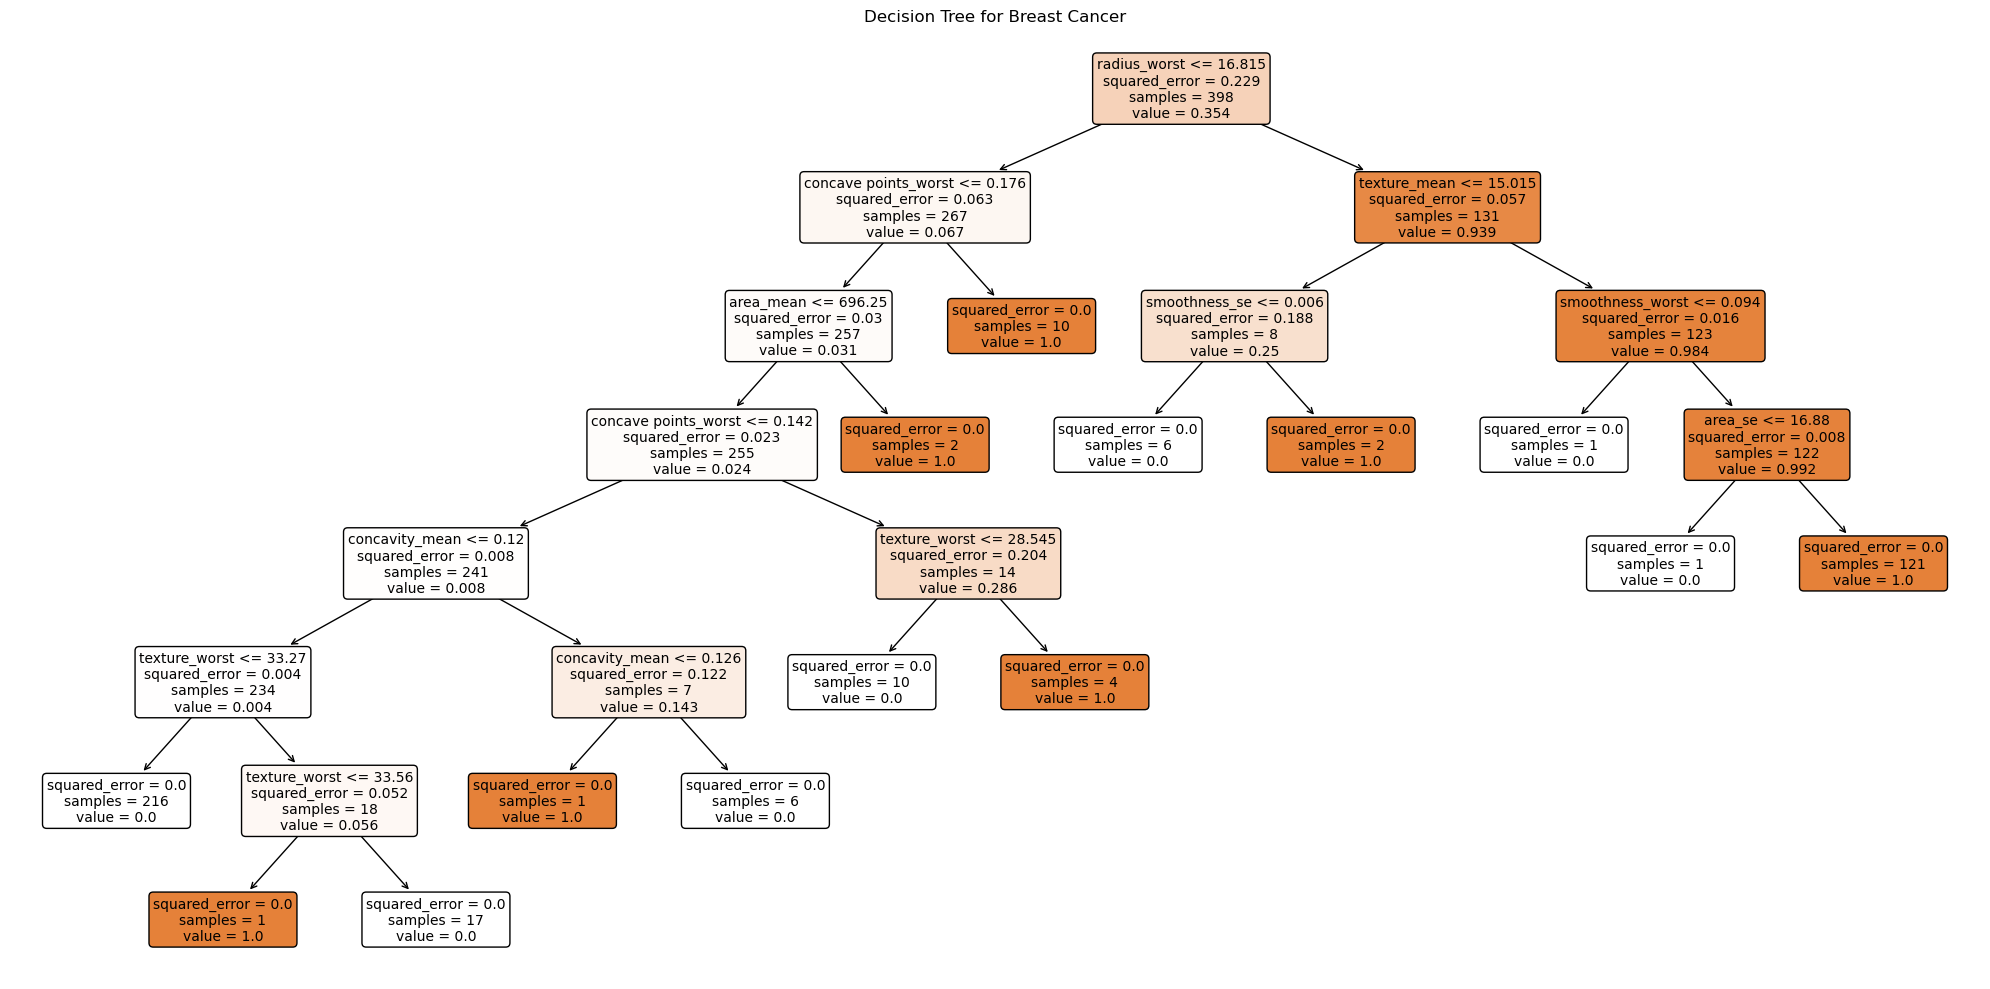

In [35]:
# plot the decision tree
plt.figure(figsize = (20, 10))
plot_tree(regressor, feature_names = X.columns.tolist(), filled = True, rounded = True, 
          fontsize = 10)
plt.title("Decision Tree for Breast Cancer")
plt.tight_layout()
plt.show()

__Interpretation:__   
Variables that appeared in the tree and are significant predictors of diagnosis are radius_worst, texture_mean, concave_points_worst, area_mean, smoothness_worst, smoothness_se, area_se, texture_worst, and concavity_mean.


---

#### d) No code required:  would you consider pruning this tree?  Why?  Where?  Explain how you would go about deciding where to prune the tree?  What measures would you use? (10 pts)

__Answer:__  
__I would consider pruning this tree__ because it helps to prevent overfitting. This tree is deep (7 layers) and a very deep tree can indicate that the model is fitting very specific to the training data, capturing noise rather than underlying patterns which lead to bad performance OOS. Moreover, there are also many small leaf nodes in this tree (samples = 1). Nodes that represent a very small number of samples might be overfitting to the training data. Thus we should cut them off by pruning.   

Pruning areas with high squared error, low sample size, or minimal impact on classification, such as nodes leading to many leaves with very few samples or those with high squared error, could be targeted when deciding where to prune.  

As for the pruning method, we can perform __cost complexity pruning__ which is to create a hyperparameter that will stop the growth of the tree when the size of leaf nodes hits a minimum threshold. The idea is to find the right balance between the tree's depth and its accuracy. We can also use __cross-validation__ to find the optimal complexity parameter (alpha) for pruning. Another solution is to let the tree grow all of the way and then prune it by __removing nodes from the bottom up__. During this process, the node with the minimal impact on decreasing variance is removed at each stage. We can then generate various potential trees and employ cross-validation to assess their out-of-sample predictive efficiency.